# 01: Data Exploration

Distributions, keyword frequencies, correlations, missing data


## **Setup**

### Imports

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from data.load import load_and_verify_graph

### Plotting Prep

In [12]:
color_top = "slateblue"
color_recent = "lightcoral"
colors = [color_top, color_recent]

def add_grid(ax, axis="x"):
    ax.set_axisbelow(True)
    ax.grid(axis=axis,  alpha=0.5)

## **Load Data**

### Load and Verify

In [13]:
GRAPH_DATA_DIR = Path("../data/graph")
GRAPH_NAME = "graph_top_n500_20250729"
G_top, df_edges_top = load_and_verify_graph(GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_top_n500_20250729':
  1,248 nodes
  500 core packages
  3,633 dependencies
  directed=True

Sample node metadata:
  pytest-cov: SourceRank=26, stars=1918, forks=217
  uv: SourceRank=22, stars=62605, forks=1800
  markupsafe: SourceRank=22, stars=636, forks=156
  apache-airflow-providers-common-sql: SourceRank=20, stars=41273, forks=15377
  rpds-py: SourceRank=19, stars=52, forks=22

Sample edge metadata:
  pytest-cov -> coverage: kind=runtime, optional=False
  pytest-cov -> pluggy: kind=runtime, optional=False
  pytest-cov -> pytest: kind=runtime, optional=False
  pytest-cov -> fields: kind=testing, optional=True
  pytest-cov -> hunter: kind=testing, optional=True


In [14]:
RECENT_GRAPH_NAME = "graph_recent_n500_20250729"
G_recent, df_edges_recent = load_and_verify_graph(RECENT_GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_recent_n500_20250729':
  2,105 nodes
  500 core packages
  4,802 dependencies
  directed=True

Sample node metadata:
  thoa: SourceRank=3, stars=0, forks=0
  pyninja-tool: SourceRank=5, stars=0, forks=0
  tobiko-cloud-pydantic: SourceRank=4, stars=0, forks=0
  karrio-boxknight: SourceRank=10, stars=625, forks=134
  dapr-agents: SourceRank=9, stars=253, forks=135

Sample edge metadata:
  pyninja-tool -> aiohttp: kind=runtime, optional=False
  pyninja-tool -> click: kind=runtime, optional=False
  pyninja-tool -> packaging: kind=runtime, optional=False
  pyninja-tool -> requests: kind=runtime, optional=False
  pyninja-tool -> rich: kind=runtime, optional=False


### Missing Metadata

In [15]:
def show_nodes_with_missing_metadata(G, max_display=20, remove=False):
    missing_metadata_nodes = [node for node, data in G.nodes(data=True) if data.get('missing_metadata')]

    if missing_metadata_nodes:
        print(f"Nodes with missing metadata: {len(missing_metadata_nodes):,}")
        print("-" * 40)
        for i, node in enumerate(missing_metadata_nodes[:max_display], 1):
            print(f"{i:3d}. {node}")
        if len(missing_metadata_nodes) > max_display:
            print(f"... and {len(missing_metadata_nodes) - max_display} more.")
        print("-" * 40)
        if remove:
            G.remove_nodes_from(missing_metadata_nodes)
            print(f"Removed {len(missing_metadata_nodes):,} nodes with missing metadata.")
    else:
        print("All nodes have complete metadata.")

print("Top packages graph:")
show_nodes_with_missing_metadata(G_top, remove=True)
print()
print("Recent packages graph:")
show_nodes_with_missing_metadata(G_recent, remove=True)

Top packages graph:
All nodes have complete metadata.

Recent packages graph:
Nodes with missing metadata: 4
----------------------------------------
  1. invoicing-pdf99
  2. yandex-robotics-trt-inference-cuda
  3. sicar
  4. thds-termtool
----------------------------------------
Removed 4 nodes with missing metadata.


## **Graph Visualization**

### Top Packages

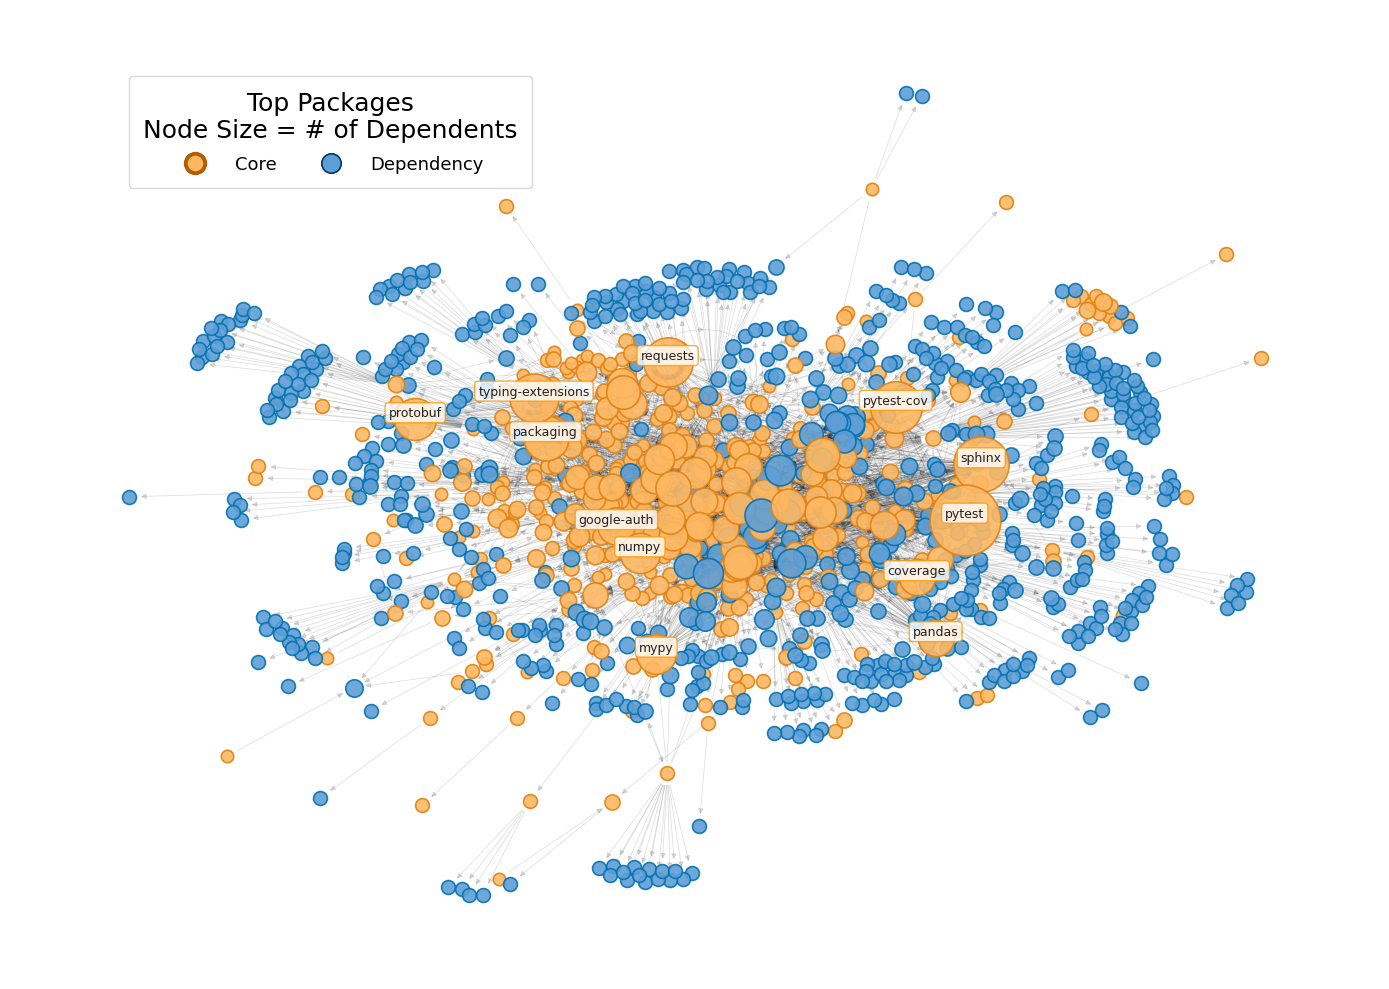

In [97]:
def plot_core_dependency_graph(G, title, max_labels=12, bbox_to_anchor=(0.08, 0.92)):
    # Find largest connected component
    comps = list(nx.weakly_connected_components(G) if nx.is_directed(G) else nx.connected_components(G))
    if not comps:
        print("No connected components found."); return
    G_sub = G.subgraph(max(comps, key=len)).copy()

    # Identify core nodes and compute node sizes
    core_nodes = [n for n, d in G_sub.nodes(data=True) if d.get("is_core", False)]
    in_deg = dict(G_sub.in_degree())
    min_deg, max_deg = (min(in_deg.values()), max(in_deg.values())) if in_deg else (0, 1)
    get_size = lambda n, mi=80, ma=2600: (mi+ma)//2 if max_deg==min_deg else mi+(ma-mi)*(in_deg.get(n,0)-min_deg)/(max_deg-min_deg)
    node_sizes = {n: get_size(n) for n in G_sub.nodes()}
    sorted_nodes = sorted(G_sub.nodes(), key=lambda n: node_sizes[n])

    # Set node and edge colors/styles
    core_color, dep_color = "#fdb863", "#5e9fd6"
    node_colors = [core_color if n in core_nodes else dep_color for n in sorted_nodes]
    node_edgecolors = ["#e08214" if n in core_nodes else "#0571b0" for n in sorted_nodes]
    node_linewidths = [1.2 for _ in sorted_nodes]
    node_alphas = [0.9 for _ in sorted_nodes]

    # Compute node positions (layout)
    if G_sub.number_of_nodes() <= 1:
        pos = {n: (0, 0) for n in G_sub.nodes()}
    else:
        pos = nx.spring_layout(G_sub, k=1.0/np.sqrt(G_sub.number_of_nodes()), iterations=200, seed=42, scale=1.5)
        if core_nodes:
            top_label_nodes = sorted(core_nodes, key=lambda n: in_deg.get(n,0), reverse=True)[:max_labels]
            angle_step, radius = 2*np.pi/max(1,len(top_label_nodes)), 0.45
            centroid = np.mean(list(pos.values()), axis=0)
            for i, n in enumerate(top_label_nodes):
                angle = i*angle_step
                direction = np.array([np.cos(angle), np.sin(angle)])
                pos[n] = tuple(centroid + (np.array(pos[n])-centroid)*1.18 + direction*radius)

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_edges(G_sub, pos, alpha=0.13, arrowsize=8, width=0.55)
    for idx, n in enumerate(sorted_nodes):
        nx.draw_networkx_nodes(G_sub, pos, nodelist=[n], node_color=node_colors[idx], node_size=node_sizes[n],
                              edgecolors=node_edgecolors[idx], linewidths=node_linewidths[idx],
                              alpha=node_alphas[idx], node_shape="o")

    # Draw labels for top core nodes
    if core_nodes:
        top_label_nodes = sorted(core_nodes, key=lambda n: in_deg.get(n,0), reverse=True)[:max_labels]
        for i, n in enumerate(top_label_nodes):
            x, y = pos[n]
            plt.text(x, y, n, fontsize=9, color="#222", ha="center", va="bottom",
                     bbox=dict(facecolor="white", edgecolor="#ff9800", alpha=0.8, boxstyle="round,pad=0.28"))

    # Add legend and finalize plot
    plt.axis("off")
    leg = plt.legend(
        handles=[
            Line2D([0], [0], marker="o", color="w", label="Core", markerfacecolor=core_color, markeredgecolor="#b35c00", markersize=14, linewidth=0, markeredgewidth=2.8),
            Line2D([0], [0], marker="o", color="w", label="Dependency", markerfacecolor=dep_color, markeredgecolor="#003366", markersize=14, linewidth=0, markeredgewidth=1.2)
        ],
        title=title, title_fontsize=18, scatterpoints=1, loc="upper left", bbox_to_anchor=bbox_to_anchor,
        ncol=2, frameon=True, fontsize=13, handletextpad=1.2, borderpad=0.8, labelspacing=0.7, fancybox=True
    )
    if leg.get_title() is not None:
        leg.get_title().set_ha("center")
    plt.tight_layout()
    plt.show()

plot_core_dependency_graph(G_top, "Top Packages\nNode Size = # of Dependents", max_labels=12, bbox_to_anchor=(0.08, 0.94))

### Recent Packages

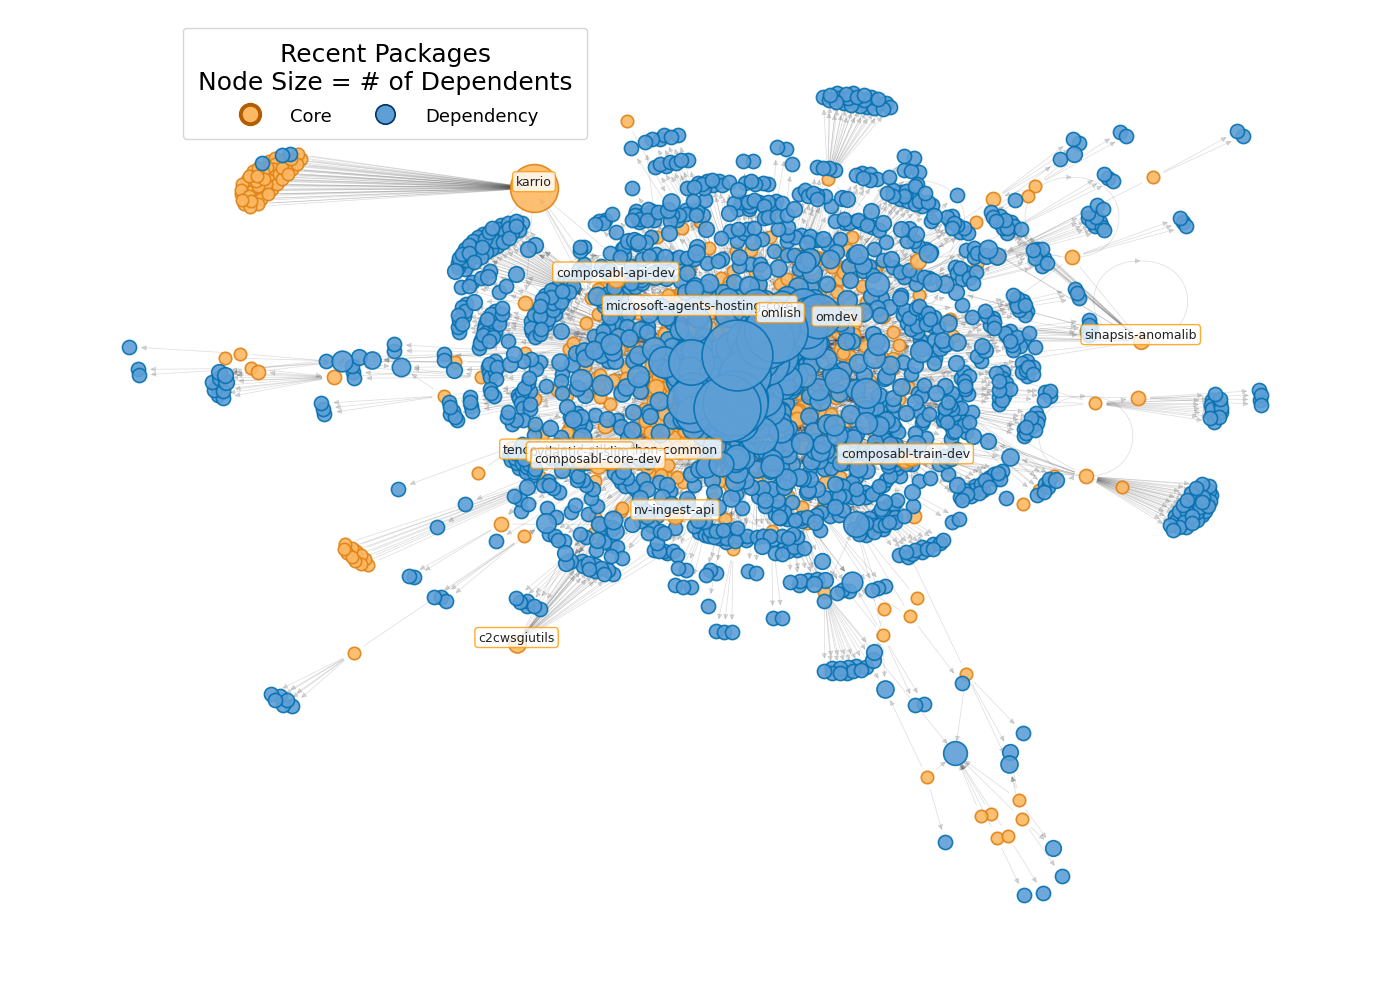

In [98]:
plot_core_dependency_graph(G_recent, "Recent Packages\nNode Size = # of Dependents", bbox_to_anchor=(0.12, 0.99))

## **Dependencies (Edges)**

### Common Dependencies

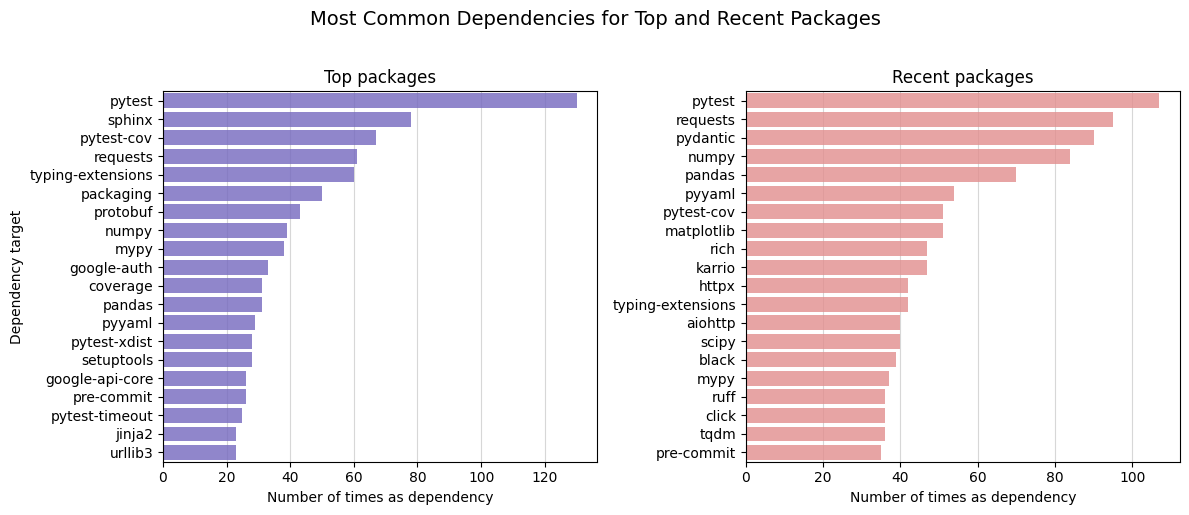

In [99]:
n = 20

top_common_targets = df_edges_top["target"].value_counts().head(n)
recent_common_targets = df_edges_recent["target"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    y=top_common_targets.index,
    x=top_common_targets.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as dependency")
axes[0].set_ylabel("Dependency target")
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_common_targets.index,
    x=recent_common_targets.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as dependency")
axes[1].set_ylabel("")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

fig.suptitle("Most Common Dependencies for Top and Recent Packages", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Most Dependencies

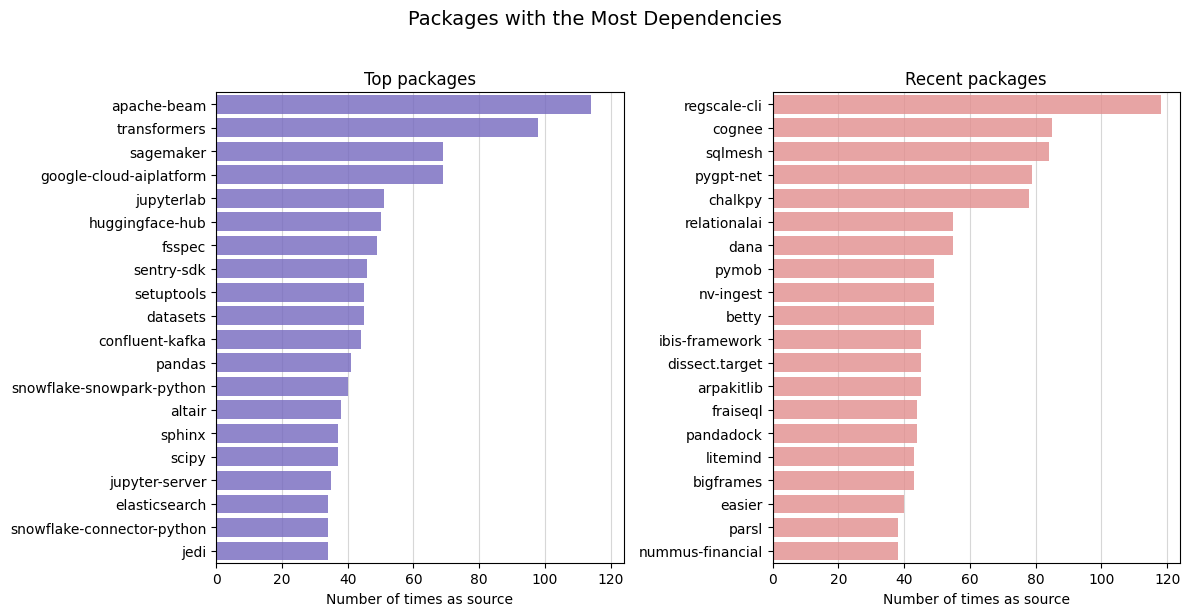

In [100]:
n = 20
top_sources = df_edges_top["source"].value_counts().head(n)
recent_sources = df_edges_recent["source"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

sns.barplot(
    y=top_sources.index,
    x=top_sources.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as source")
axes[0].set_ylabel(None)
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_sources.index,
    x=recent_sources.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as source")
axes[1].set_ylabel(None)
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

# Add grid lines
fig.suptitle("Packages with the Most Dependencies", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Optional Dependency Proportions

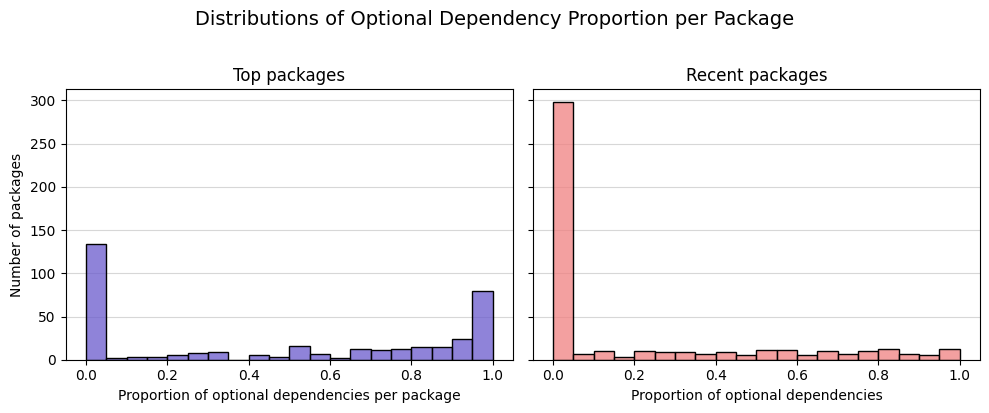

In [101]:
# Compute proportion of optional dependencies per source package for both DataFrames
prop_top = (
    df_edges_top.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)
prop_recent = (
    df_edges_recent.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)

# Top packages
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
sns.histplot(prop_top, bins=20, color=color_top, kde=False, ax=axes[0])
axes[0].set_xlabel("Proportion of optional dependencies per package")
axes[0].set_ylabel("Number of packages")
axes[0].set_title("Top packages")

# Recent packages
sns.histplot(prop_recent, bins=20, color=color_recent, kde=False, ax=axes[1])
axes[1].set_xlabel("Proportion of optional dependencies")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax, "y")

fig.suptitle("Distributions of Optional Dependency Proportion per Package", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

* pytest and requests are common dependencies.
* Top packages have a more skewed distribution with fewer dependencies in general.
* Top packages are notably less likely to have no optional dependencies, and more likely to have only optional dependencies.
* fsspec stands out as having the most dependencies among the top packages at 50.
  * A high number of dependencies such as this may be anomalous for less established packages.

## **Projects (Nodes)**

### Extract Node Features

In [104]:
def get_core_nodes_df(G):
    df = pd.DataFrame([
        {"name": node, **data}
        for node, data in G.nodes(data=True) if data.get("is_core")
    ])
    if "latest_release" in df.columns:
        df["latest_release"] = pd.to_datetime(df["latest_release"], errors="coerce")
    return df

df_nodes_top = get_core_nodes_df(G_top)
df_nodes_recent = get_core_nodes_df(G_recent)

### Package Metadata Overview

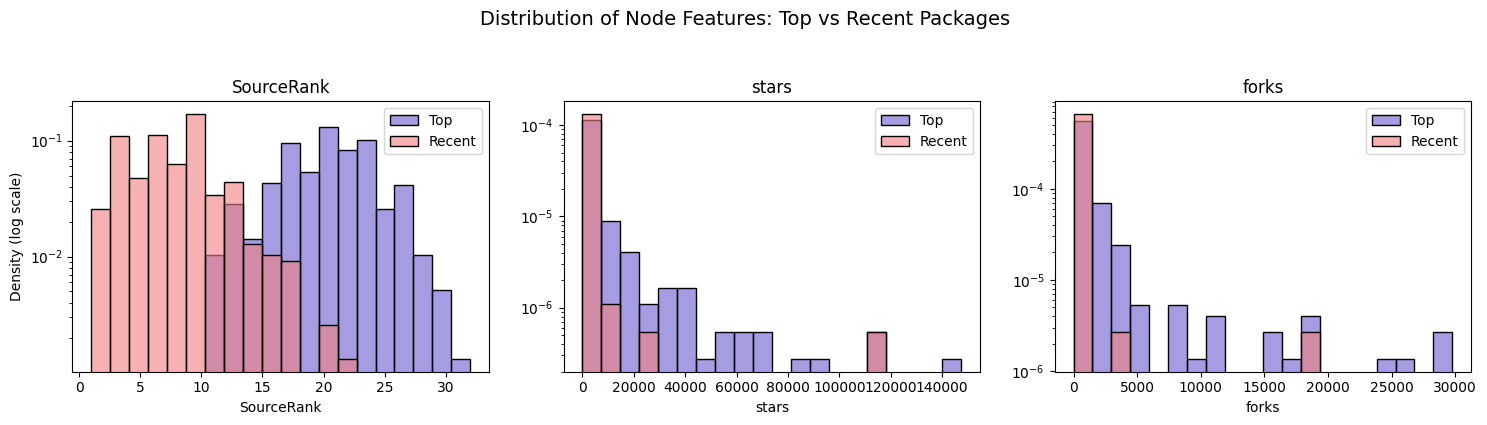

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

features = ["SourceRank", "stars", "forks"]

for i, feature in enumerate(features):
    # Compute min and max for both datasets to get consistent bin edges
    data_top = df_nodes_top[feature]
    data_recent = df_nodes_recent[feature]
    data_all = pd.concat([data_top, data_recent])
    min_val = data_all.min()
    max_val = data_all.max()

    # Use 20 bins
    bin_width = (max_val - min_val) / 20 if max_val > min_val else 1
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    sns.histplot(data_top, bins=bins, color=colors[0], label="Top", ax=axes[i], alpha=0.6, stat="density")
    sns.histplot(data_recent, bins=bins, color=colors[1], label="Recent", ax=axes[i], alpha=0.6, stat="density")
    axes[i].set_title(features[i])
    axes[i].set_xlabel(feature)
    axes[i].set_yscale("log")  # Set y-axis to log scale
    if i == 0:
        axes[i].set_ylabel("Density (log scale)")
    else:
        axes[i].set_ylabel("")
    axes[i].legend()

fig.suptitle("Distribution of Node Features: Top vs Recent Packages", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

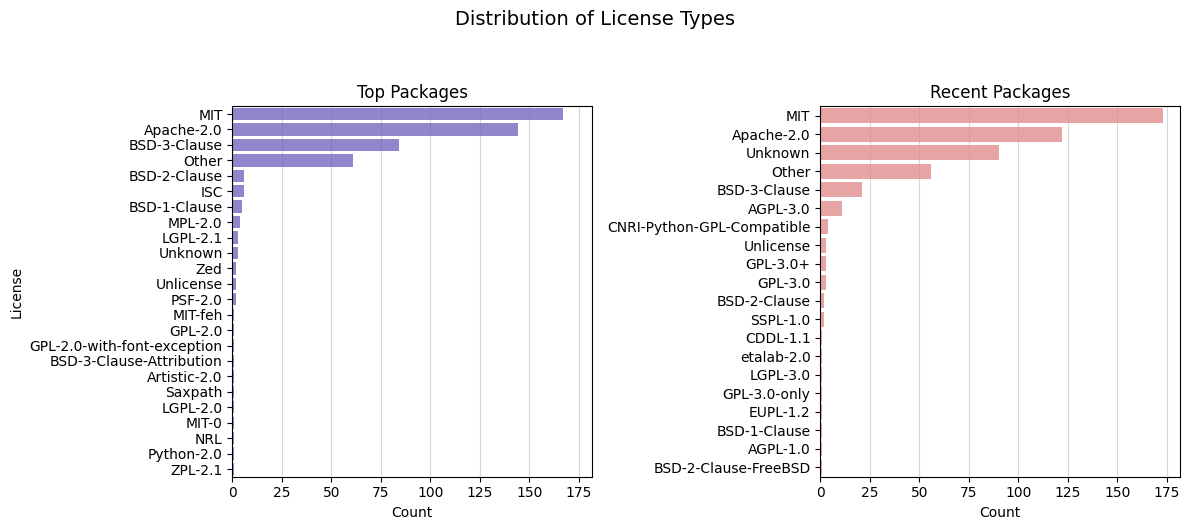

In [106]:
# Plot and compare license value counts for df_nodes_top and df_nodes_recent

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Top packages
license_counts_top = df_nodes_top["license"].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_top.values, y=license_counts_top.index, ax=axes[0], color=color_top, alpha=0.8)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("License")

# Recent packages
license_counts_recent = df_nodes_recent["license"].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_recent.values, y=license_counts_recent.index, ax=axes[1], color=color_recent, alpha=0.8)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

for ax in axes:
    add_grid(ax)

fig.suptitle("Distribution of License Types", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### SourceRank Metric Correlation

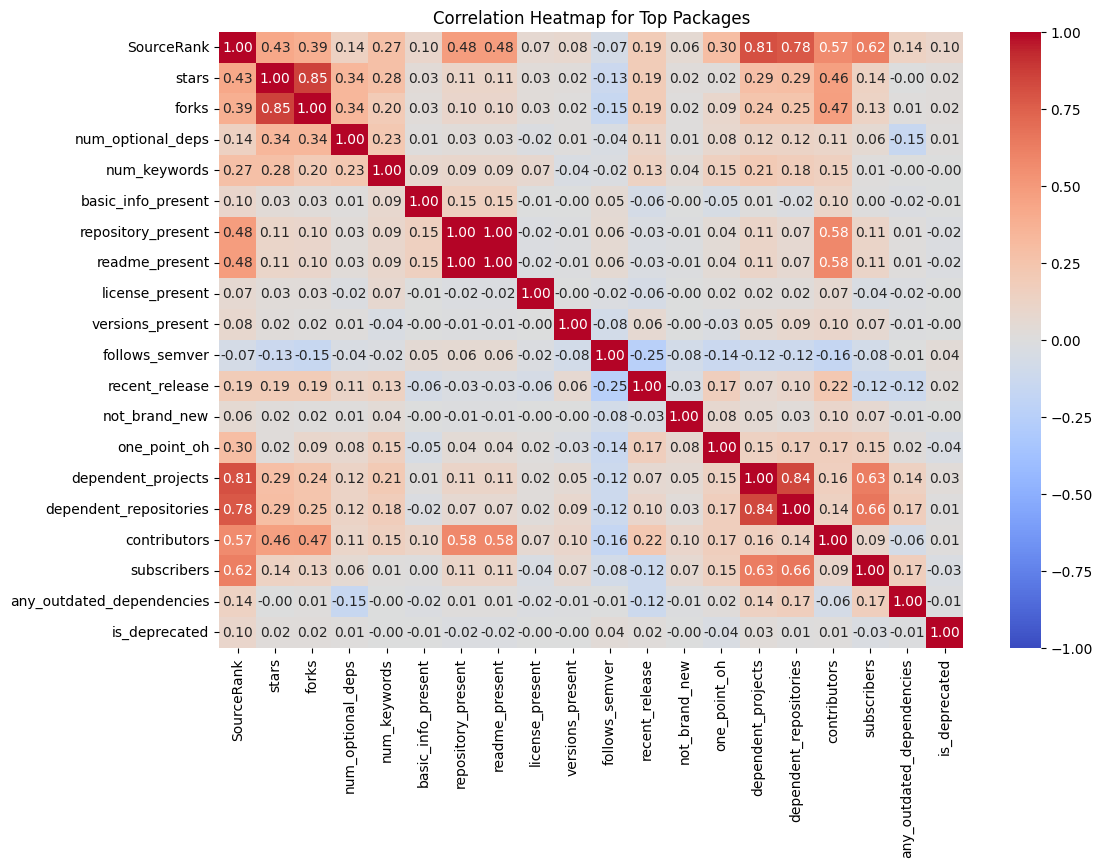

In [124]:
def plot_correlation_heatmap(df, title, figsize=(12, 8)):
    numeric_cols = df.select_dtypes(include=["int64", "float64"])
    corr = numeric_cols.corr().dropna(axis=0, how="all").dropna(axis=1, how="all")
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

plot_correlation_heatmap(df_nodes_top, "Correlation Heatmap for Top Packages")

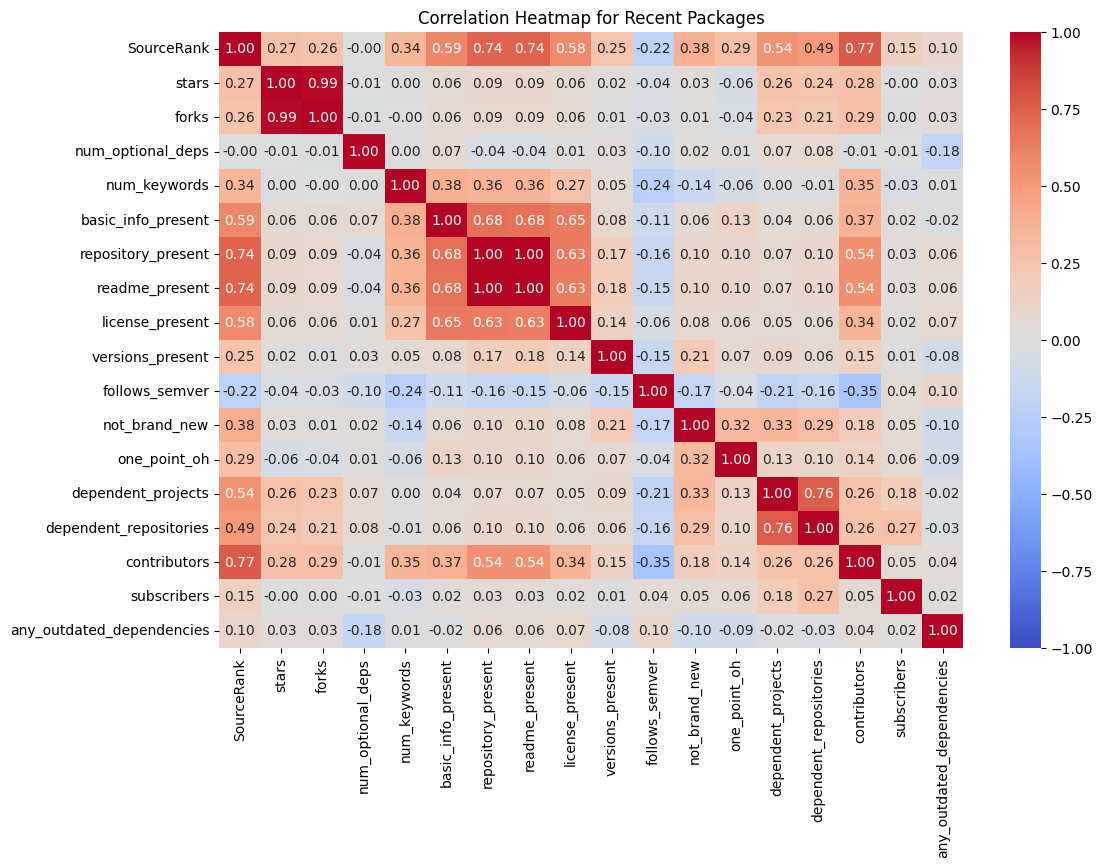

In [125]:
plot_correlation_heatmap(df_nodes_recent, "Correlation Heatmap for Recent Packages")

### Copycats (Projects in Same Repo)

In [111]:
def get_copycat_repo_details(df):
    copycats = df[(df["is_copycat"])]
    if copycats.empty:
        return copycats

    # Group by repo_url and aggregate details
    grouped = (
        copycats
        .groupby("repo_url", as_index=False)
        .agg(
            count=("name", "size"),
            name=("name", lambda x: ", ".join(sorted(set(x)))),
            stars=("stars", "max"),
            forks=("forks", "max")
        )
        .sort_values(["count", "repo_url"], ascending=[False, True])
    )
    return grouped

top_copycat_details = get_copycat_repo_details(df_nodes_top)
recent_copycat_details = get_copycat_repo_details(df_nodes_recent)

print("Top packages with shared repository url and metadata:")
display(top_copycat_details)

print("\nRecent packages with shared repository url and metadata:")
display(recent_copycat_details)

Top packages with shared repository url and metadata:


,repo_url,count,name,stars,forks
3,https://github.com/googleapis/google-cloud-python,16,"google-analytics-admin, google-cloud-appengine...",5075,1590
6,https://github.com/open-telemetry/opentelemetr...,9,"opentelemetry-api, opentelemetry-exporter-otlp...",2068,717
0,https://github.com/Azure/azure-sdk-for-python,7,"azure-common, azure-core, azure-identity, azur...",5008,3060
8,https://github.com/python/typeshed,4,"types-protobuf, types-python-dateutil, types-p...",4755,1886
7,https://github.com/open-telemetry/opentelemetr...,3,"opentelemetry-instrumentation, opentelemetry-i...",872,744
1,https://github.com/Legrandin/pycryptodome,2,"pycryptodome, pycryptodomex",3006,538
2,https://github.com/certbot/certbot,2,"acme, certbot-dns-cloudflare",32247,3429
4,https://github.com/grpc/grpc,2,"grpcio, grpcio-tools",43381,10853
5,https://github.com/langchain-ai/langchain,2,"langchain, langchain-core",112416,18356
9,https://github.com/tensorflow/tensorboard,2,"tb-nightly, tensorboard",6942,1674



Recent packages with shared repository url and metadata:


,repo_url,count,name,stars,forks
10,https://github.com/karrioapi/karrio,56,"karrio, karrio-allied-express, karrio-allied-e...",625,134
5,https://github.com/TencentCloud/tencentcloud-s...,13,"tencentcloud-sdk-python, tencentcloud-sdk-pyth...",655,251
12,https://github.com/microsoft/Agents,8,"microsoft-agents-activity, microsoft-agents-au...",355,117
14,https://github.com/wrmsr/omlish,7,"omdev, omdev-cext, omdev-cli, ominfra, omlish,...",4,0
9,https://github.com/karellen/karellen-llvm,5,"karellen-llvm-clang, karellen-llvm-core, karel...",4,0
1,https://github.com/HaizeaAnalytics/terrakio-py...,3,"terrakio-admin-api, terrakio-api, terrakio-core",0,0
2,https://github.com/NVIDIA/nv-ingest,3,"nv-ingest, nv-ingest-api, nv-ingest-client",2724,258
7,https://github.com/TrilliantHealth/trilliant-d...,3,"thds.adls, thds.atacama, thds.core",5,0
8,https://github.com/camptocamp/c2cgeoportal,3,"c2cgeoportal-admin, c2cgeoportal-commons, c2cg...",66,45
13,https://github.com/pydantic/pydantic-ai,3,"pydantic-ai, pydantic-evals, pydantic-graph",11296,1081


## **Graph Structure**

### Degree Distributions

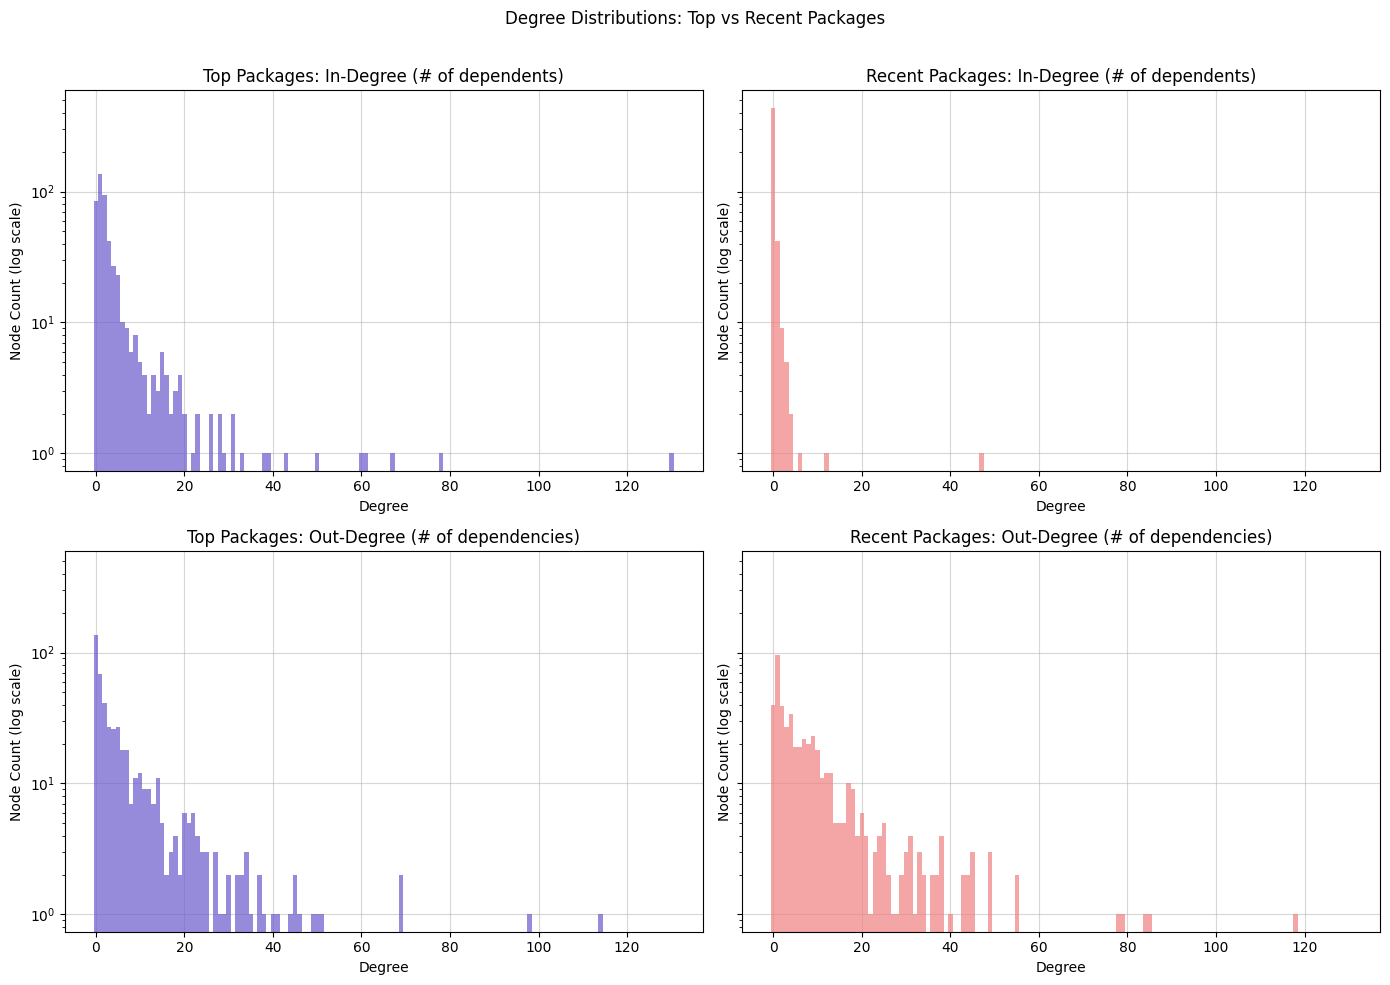

In [113]:
def plot_degree_comparison_core_only(G_top, G_recent, color_top, color_recent, title_prefix=""):
    def degree_lists_core(G):
        # Only include nodes where core=True
        core_nodes = [n for n, d in G.nodes(data=True) if d.get("is_core", False)]
        in_deg = [G.in_degree(n) for n in core_nodes]
        out_deg = [G.out_degree(n) for n in core_nodes]
        return in_deg, out_deg

    in_deg_top, out_deg_top = degree_lists_core(G_top)
    in_deg_recent, out_deg_recent = degree_lists_core(G_recent)

    # Combine all degrees to get global min/max for binning
    all_degrees = in_deg_top + in_deg_recent + out_deg_top + out_deg_recent
    if not all_degrees:
        print("No core nodes found in either graph.")
        return
    deg_min, deg_max = min(all_degrees), max(all_degrees)
    bins = np.arange(deg_min, deg_max + 2) - 0.5  # so each integer is its own bin

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

    # Prepare data and labels for each subplot to avoid repetition
    plot_configs = [
        # (row, col, data, color, title)
        (0, 0, in_deg_top, color_top, "Top Packages: In-Degree (# of dependents)"),
        (0, 1, in_deg_recent, color_recent, "Recent Packages: In-Degree (# of dependents)"),
        (1, 0, out_deg_top, color_top, "Top Packages: Out-Degree (# of dependencies)"),
        (1, 1, out_deg_recent, color_recent, "Recent Packages: Out-Degree (# of dependencies)"),
    ]

    for row, col, data, color, title in plot_configs:
        ax = axes[row, col]
        ax.hist(data, bins=bins, color=color, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("Degree")
        ax.set_ylabel("Node Count (log scale)")
        ax.set_yscale("log")
        add_grid(ax, "y")
        add_grid(ax, "x")

    plt.suptitle(title_prefix)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_degree_comparison_core_only(
    G_top, G_recent, color_top, color_recent,
    title_prefix="Degree Distributions: Top vs Recent Packages"
)


### Clustering Coefficient

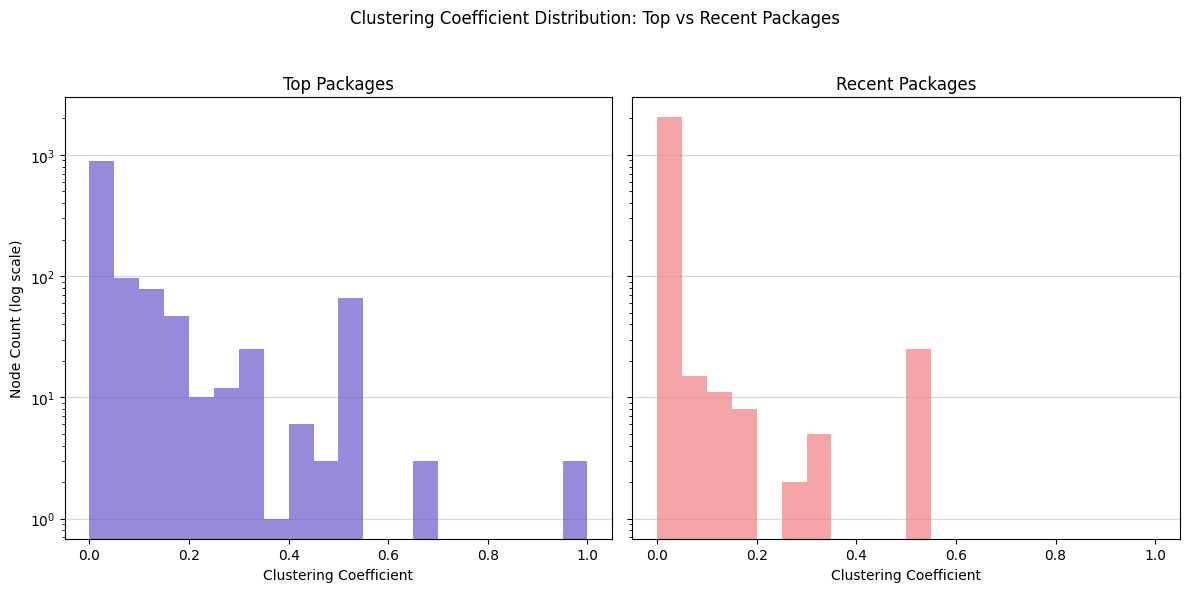

In [117]:
# Compute clustering coefficients for each node in both graphs
clustering_top = nx.clustering(G_top)
clustering_recent = nx.clustering(G_recent)

# Extract coefficient values
coeffs_top = list(clustering_top.values())
coeffs_recent = list(clustering_recent.values())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
bins = np.linspace(0, 1, 21)

axes[0].hist(coeffs_top, bins=bins, alpha=0.7, color=color_top)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Clustering Coefficient")
axes[0].set_ylabel("Node Count (log scale)")
axes[0].set_yscale("log")
add_grid(axes[0], "y")

axes[1].hist(coeffs_recent, bins=bins, alpha=0.7, color=color_recent)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Clustering Coefficient")
axes[1].set_yscale("log")
add_grid(axes[1], "y")

plt.suptitle("Clustering Coefficient Distribution: Top vs Recent Packages")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Centrality Measures

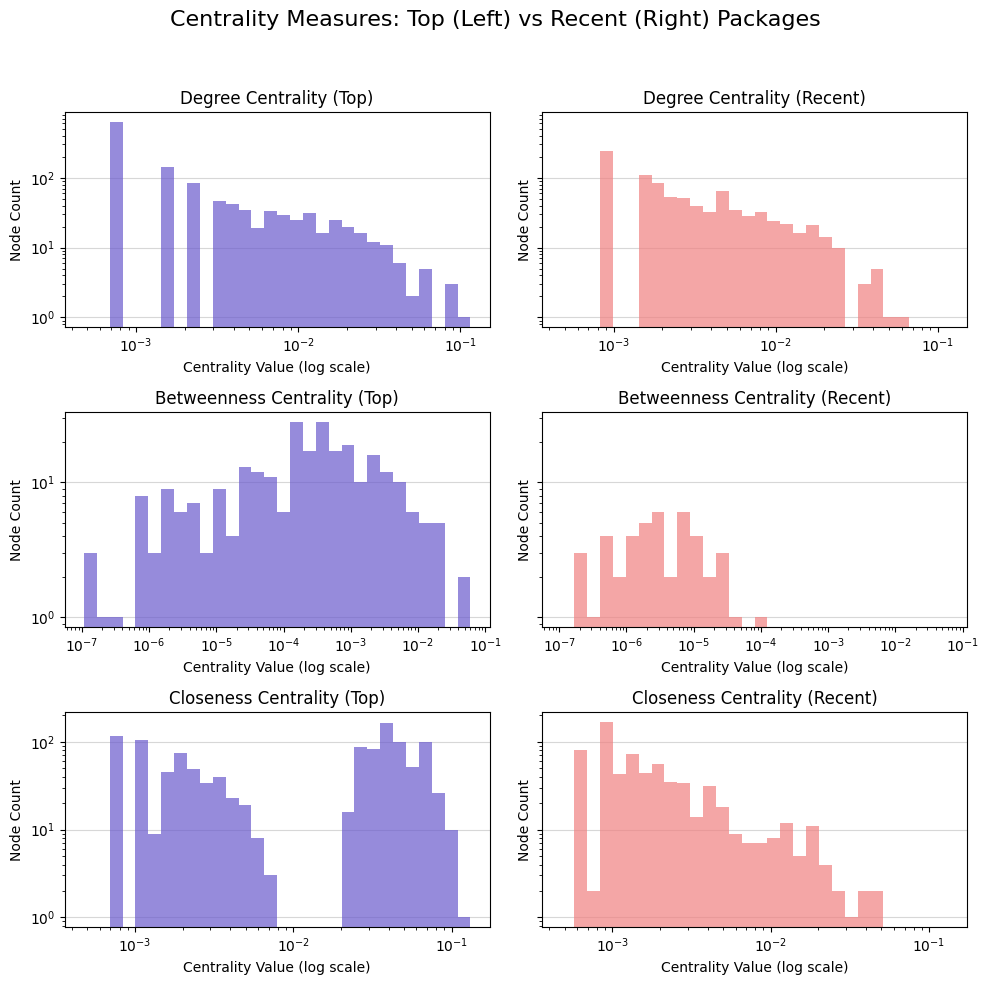

In [126]:
degree_top = nx.degree_centrality(G_top)
degree_recent = nx.degree_centrality(G_recent)

betweenness_top = nx.betweenness_centrality(G_top)
betweenness_recent = nx.betweenness_centrality(G_recent)

closeness_top = nx.closeness_centrality(G_top)
closeness_recent = nx.closeness_centrality(G_recent)

centrality_measures = [
    ("Degree", degree_top, degree_recent),
    ("Betweenness", betweenness_top, betweenness_recent),
    ("Closeness", closeness_top, closeness_recent),
]

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey='row', sharex="row")

for i, (name, top_dict, recent_dict) in enumerate(centrality_measures):
    top_vals = np.array(list(top_dict.values()))
    recent_vals = np.array(list(recent_dict.values()))
    top_vals = top_vals[top_vals > 0]
    recent_vals = recent_vals[recent_vals > 0]

    all_values = np.concatenate([top_vals, recent_vals])
    if all_values.size == 0:
        bins = 10
    else:
        min_val = all_values.min()
        max_val = all_values.max()
        if min_val == max_val:
            bins = 10
        else:
            # Use logspace for bins
            bins = np.logspace(np.log10(min_val), np.log10(max_val), 31)

    # Left column: Top
    axes[i, 0].hist(
        top_vals, bins=bins, alpha=0.7, color=color_top
    )
    axes[i, 0].set_title(f"{name} Centrality (Top)")
    axes[i, 0].set_xlabel("Centrality Value (log scale)")
    axes[i, 0].set_ylabel("Node Count")
    axes[i, 0].set_yscale("log")
    axes[i, 0].set_xscale("log")
    add_grid(axes[i, 0], "y")

    # Right column: Recent
    axes[i, 1].hist(
        recent_vals, bins=bins, alpha=0.7, color=color_recent
    )
    axes[i, 1].set_title(f"{name} Centrality (Recent)")
    axes[i, 1].set_xlabel("Centrality Value (log scale)")
    axes[i, 1].set_ylabel("Node Count")
    axes[i, 1].set_xscale("log")
    axes[i, 1].set_yscale("log")
    add_grid(axes[i, 1], "y")

plt.suptitle("Centrality Measures: Top (Left) vs Recent (Right) Packages", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Community Detection and Outliers

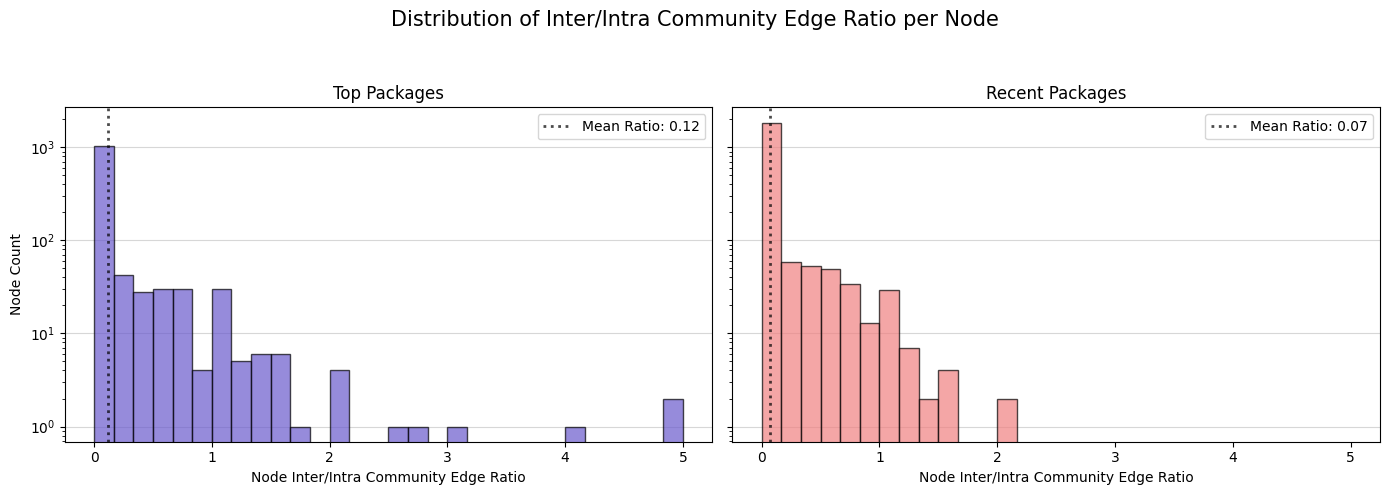

In [119]:
def compute_inter_intra_ratios(G):
    comms = list(greedy_modularity_communities(G))
    node2comm = {n: i for i, c in enumerate(comms) for n in c}
    ratios = []
    for node in G.nodes():
        comm = node2comm.get(node)
        if comm is None: continue
        intra = sum(node2comm.get(nb) == comm for nb in G.neighbors(node))
        inter = sum(node2comm.get(nb) != comm for nb in G.neighbors(node))
        ratios.append(float("inf") if intra == 0 and inter > 0 else (inter / intra if intra else 0))
    return ratios

ratios_top = compute_inter_intra_ratios(G_top)
ratios_recent = compute_inter_intra_ratios(G_recent)
finite_top = [r for r in ratios_top if np.isfinite(r)]
finite_recent = [r for r in ratios_recent if np.isfinite(r)]

all_finite = np.concatenate([finite_top, finite_recent])
if all_finite.size:
    minr, maxr = all_finite.min(), all_finite.max()
    bins = 10 if minr == maxr else np.linspace(minr, maxr, 31)
else:
    bins = 10

mean_top = np.mean(finite_top) if finite_top else 0
mean_recent = np.mean(finite_recent) if finite_recent else 0

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for ax, vals, color, title, mean_val in zip(
    axes, [finite_top, finite_recent], [color_top, color_recent], ["Top Packages", "Recent Packages"], [mean_top, mean_recent]
):
    ax.hist(vals, bins=bins, color=color, edgecolor="k", alpha=0.7)
    ax.axvline(mean_val, color="black", linestyle=":", linewidth=2, label=f"Mean Ratio: {mean_val:.2f}", alpha=0.7)
    ax.set_xlabel("Node Inter/Intra Community Edge Ratio")
    ax.set_title(title)
    ax.set_yscale("log")
    add_grid(ax, "y")
    ax.legend()
axes[0].set_ylabel("Node Count")
plt.suptitle("Distribution of Inter/Intra Community Edge Ratio per Node", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### SourceRank/Structure Feature Comparison

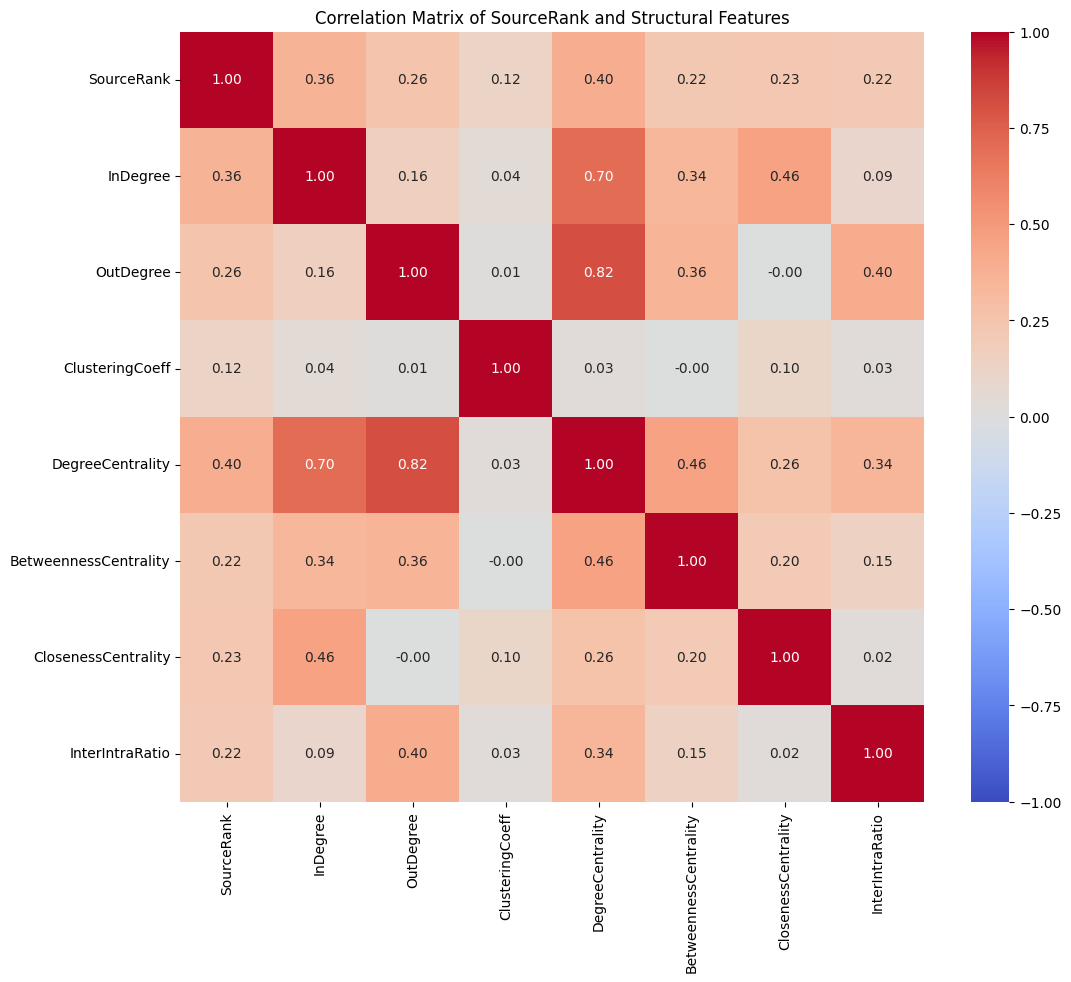

In [122]:
def plot_sourcerank_structural_features(
    G, degree_centrality=None, betweenness=None,
    closeness=None, clustering=None, inter_intra_ratios=None
):
    nodes = list(G.nodes())
    get_val = lambda d, n, i: (d.get(n, np.nan) if isinstance(d, dict) else (d[i] if d is not None and i < len(d) else np.nan))
    data = [{
        "SourceRank": G.nodes[n].get("SourceRank", np.nan),
        "InDegree": G.in_degree(n) if hasattr(G, "in_degree") else np.nan,
        "OutDegree": G.out_degree(n) if hasattr(G, "out_degree") else np.nan,
        "ClusteringCoeff": get_val(clustering, n, i),
        "DegreeCentrality": get_val(degree_centrality, n, i),
        "BetweennessCentrality": get_val(betweenness, n, i),
        "ClosenessCentrality": get_val(closeness, n, i),
        "InterIntraRatio": (
            inter_intra_ratios.get(n, np.nan) if isinstance(inter_intra_ratios, dict)
            else (inter_intra_ratios[i] if inter_intra_ratios is not None and i < len(inter_intra_ratios) else np.nan)
        )
    } for i, n in enumerate(nodes)]
    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        df.corr(),
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1, vmax=1
    )
    plt.title("Correlation Matrix of SourceRank and Structural Features")
    plt.show()

    return df

df_scatter_top = plot_sourcerank_structural_features(
    G_top,
    degree_centrality=degree_top,
    betweenness=betweenness_top,
    closeness=closeness_top,
    clustering=clustering_top,
    inter_intra_ratios=ratios_top,
)

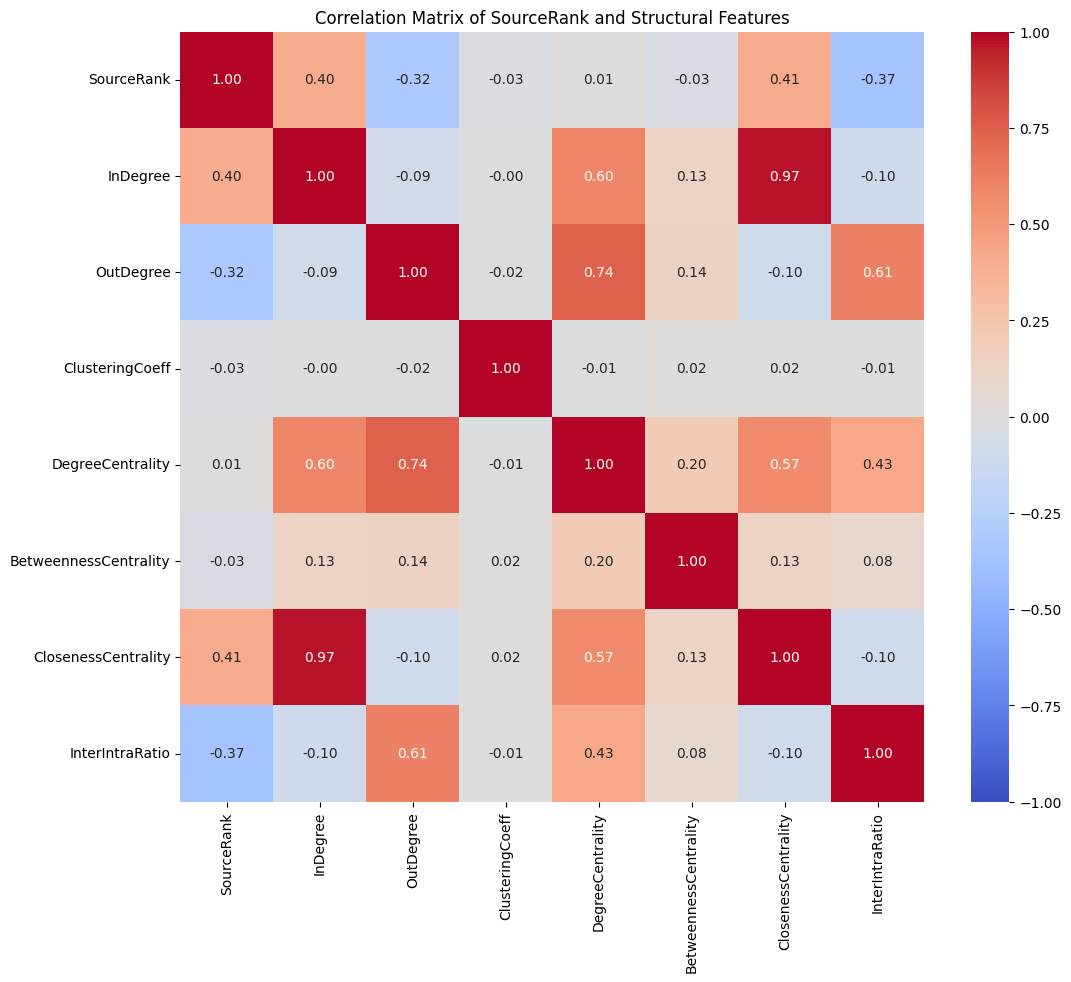

In [123]:
df_scatter_recent = plot_sourcerank_structural_features(
    G_recent,
    degree_centrality=degree_recent,
    betweenness=betweenness_recent,
    closeness=closeness_recent,
    clustering=clustering_recent,
    inter_intra_ratios=ratios_recent,
)

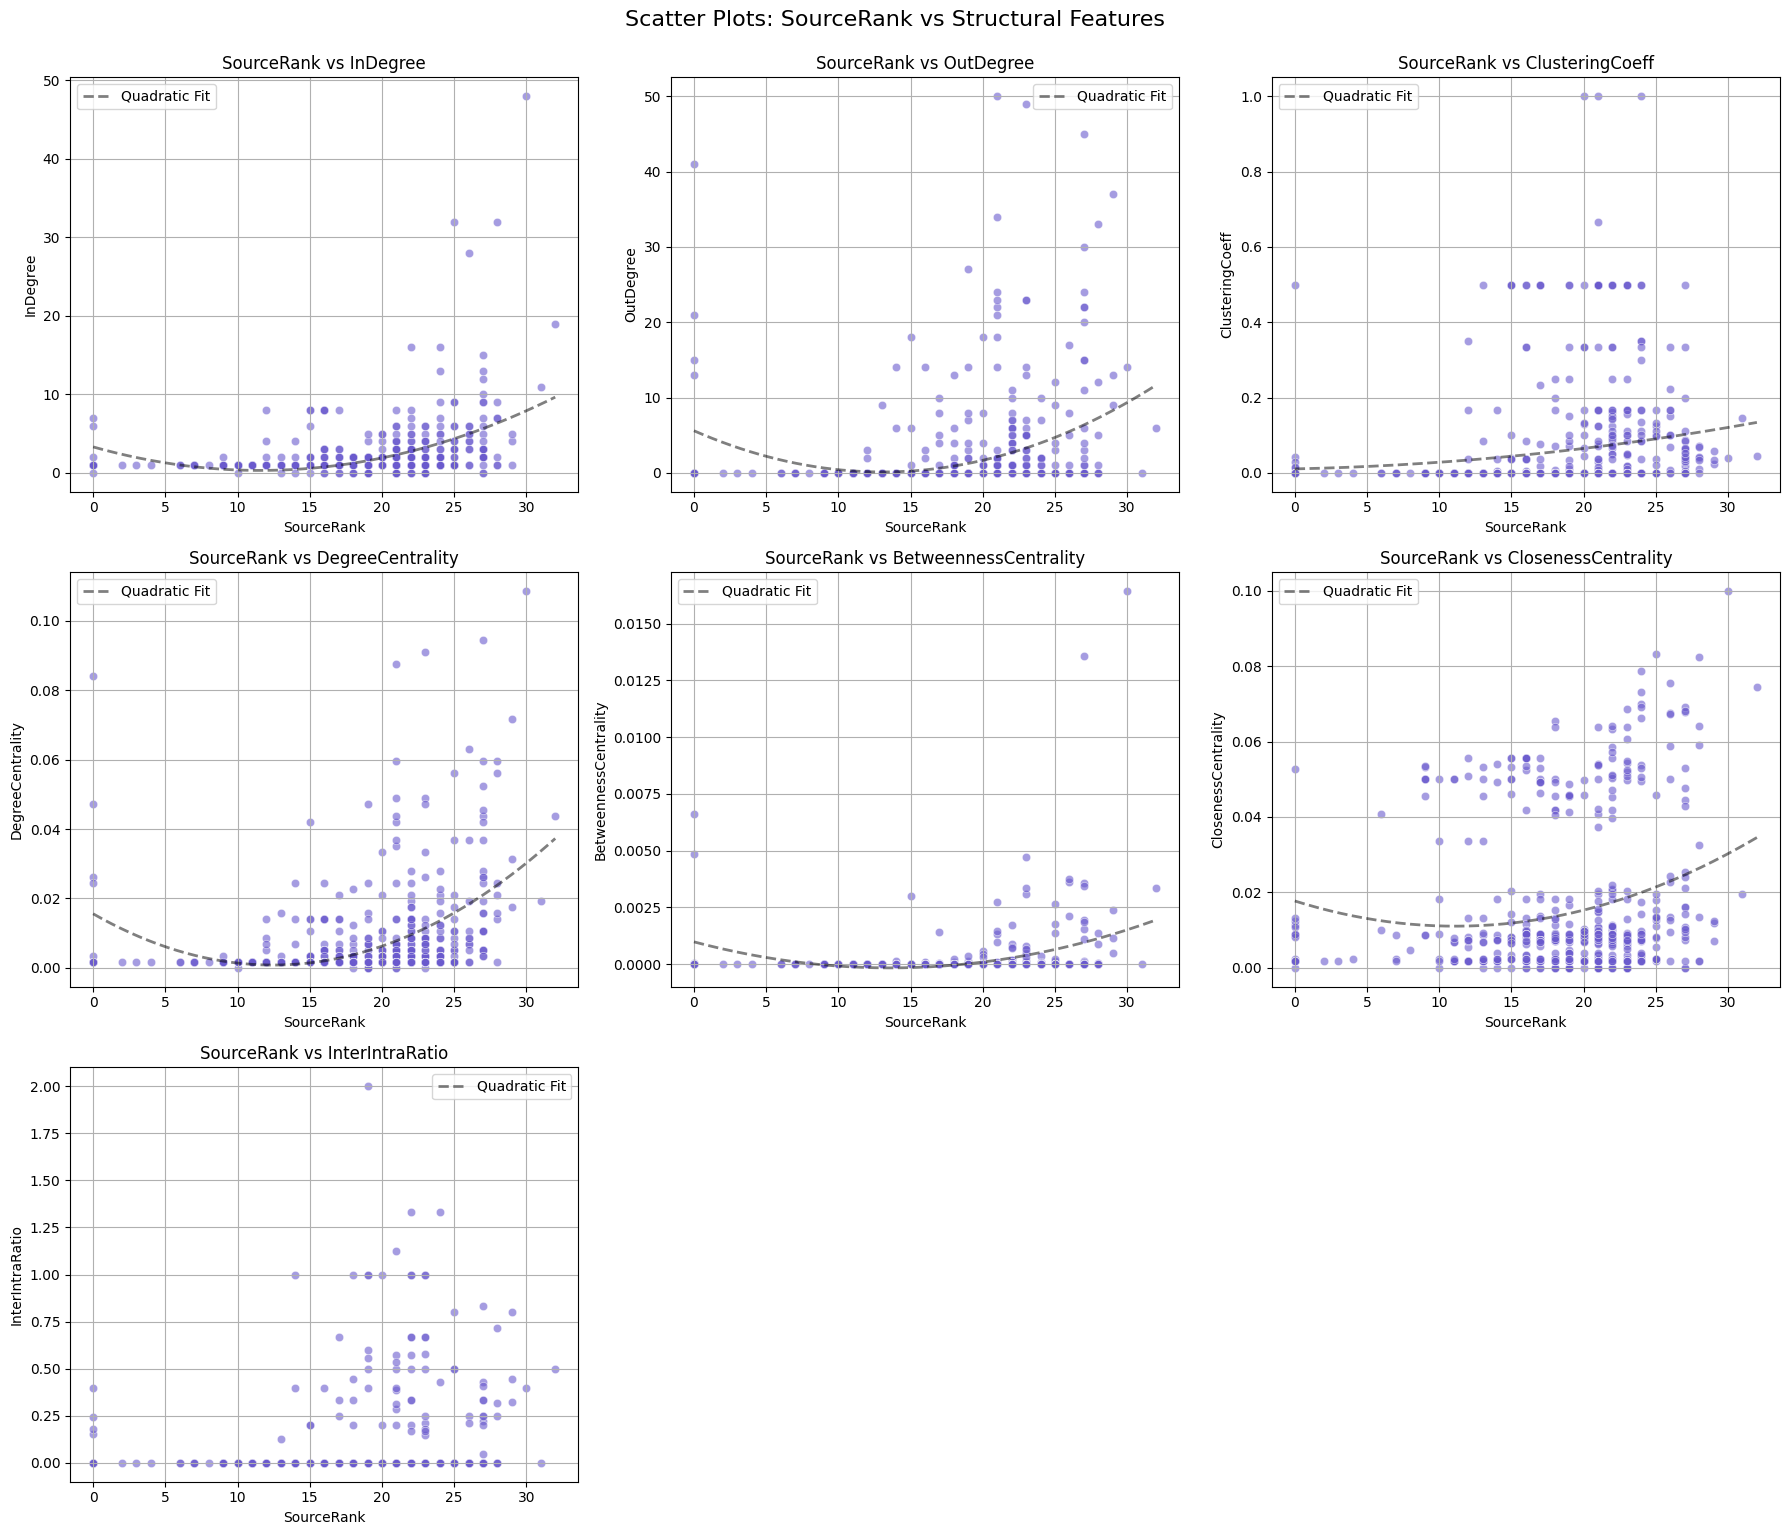

In [22]:
def plot_sourcerank_scatter_matrix(df, color):
    features = [
        "InDegree", "OutDegree", "ClusteringCoeff", "DegreeCentrality",
        "BetweennessCentrality", "ClosenessCentrality", "InterIntraRatio"
    ]
    n_cols = 3
    n_rows = int(np.ceil(len(features)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.scatterplot(x="SourceRank", y=feature, data=df, ax=axes[i], alpha=0.6, color=color)
        # Fit and plot 2nd degree polynomial
        x = df["SourceRank"].values
        y = df[feature].values
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 2:
            coeffs = np.polyfit(x[mask], y[mask], 2)
            poly = np.poly1d(coeffs)
            x_fit = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 200)
            y_fit = poly(x_fit)
            axes[i].plot(x_fit, y_fit, color="black", linestyle="--", linewidth=2, alpha=0.5, label="Quadratic Fit")
            axes[i].legend()
        axes[i].set_title(f"SourceRank vs {feature}")
        axes[i].grid(True)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.suptitle("Scatter Plots: SourceRank vs Structural Features", y=1.02, fontsize=16)
    plt.show()

plot_sourcerank_scatter_matrix(df_scatter_top, color_top)

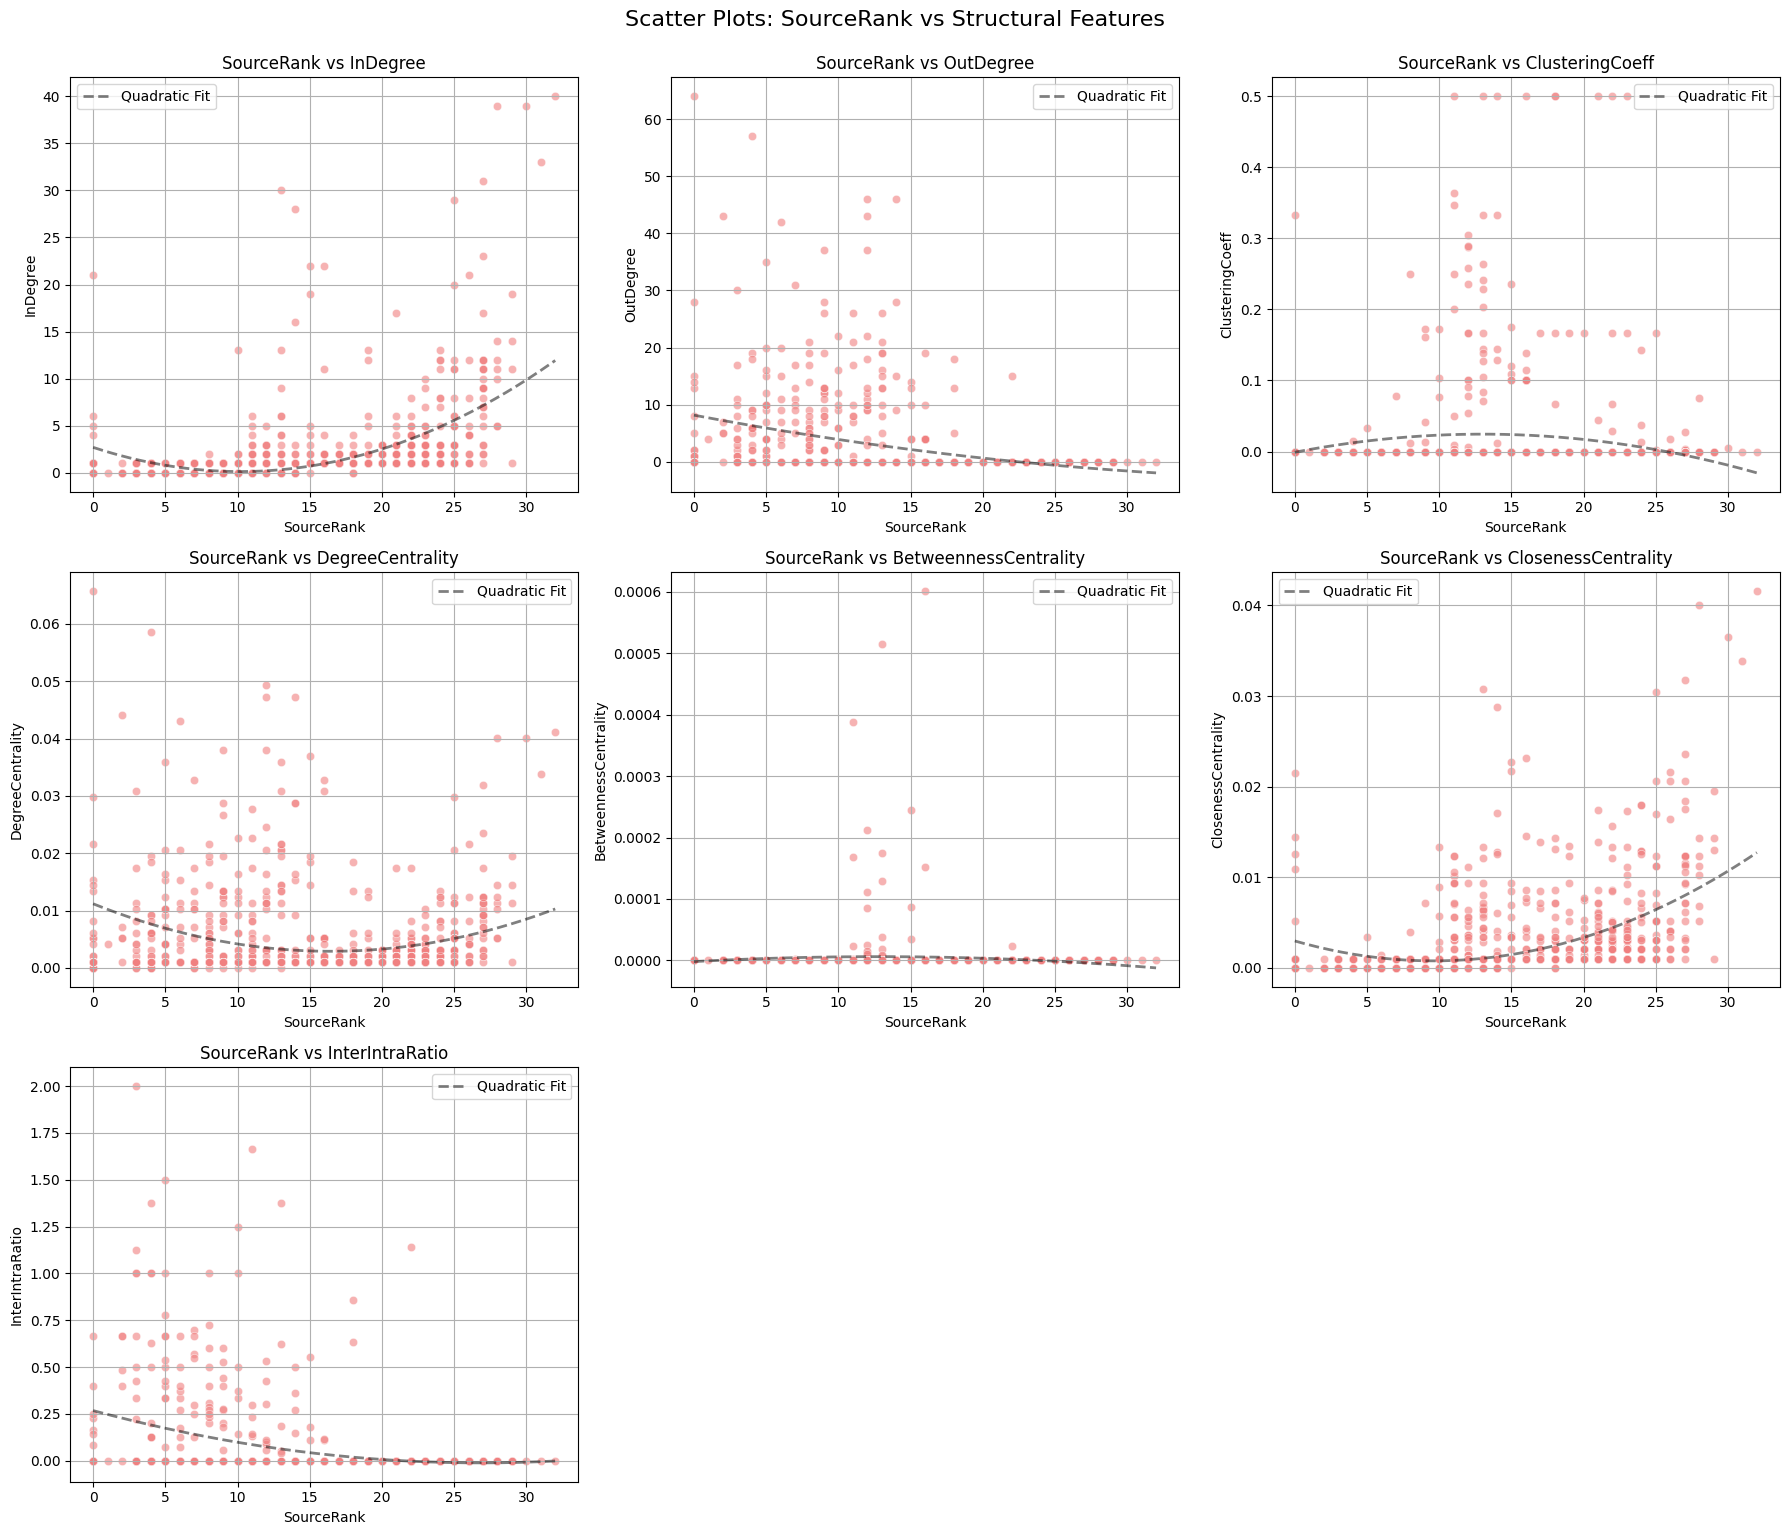

In [23]:
plot_sourcerank_scatter_matrix(df_scatter_recent, color_recent)